In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.odr as odr
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, RealData
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
from scipy import optimize, constants
from scipy.optimize import brentq, minimize_scalar
from functools import partial

In [64]:
def swap_ev_and_nm(v: float) -> float:
    # Convert an energy in eV to a wavelength in nm, and vice-versa
    return 1240 / v

def obtener_variables(url):
  df = pd.read_csv(url, sep='\t')
  x = np.array(df.iloc[1:,0].dropna(), dtype=float) #longitud de onda en nm
  y = np.array(df.iloc[1:,1].dropna(), dtype=float) #absorbancia
  return x , y

def gaussianas_odr(beta, x):
    # beta = [A1, mu1, sigma1, A2, mu2, sigma2, offset]
    A1, mu1, s1, A2, mu2, s2, offset = beta
    g1 = A1 * np.exp(- (x - mu1)**2 / (2 * s1**2))
    g2 = A2 * np.exp(- (x - mu2)**2 / (2 * s2**2))
    return g1 + g2 + offset

def gaussiana(x, A, mu, sigma, offset):
    return A * np.exp(- (x - mu)**2 / (2 * sigma**2))+offset

def ajuste_gaussianas(x, y, errx, erry, beta0):
  model = Model(gaussianas_odr)
  data = RealData(x, y, sx = errx, sy = erry)
  odr = ODR(data, model, beta0=beta0)
  out = odr.run()
  params = out.beta
  params_err = out.sd_beta
  return params, params_err

def lineal(beta, x):
  return beta[0]*x + beta[1]

def ajuste_lineal(x, y, errx, erry, beta0):
  model = Model(lineal)
  data = RealData(x, y, sx = errx, sy = erry)
  odr = ODR(data, model, beta0=beta0)
  out = odr.run()
  params = out.beta
  params_err = out.sd_beta
  return params, params_err

m_e = constants.m_e
h = constants.h*10**(18)
c = constants.c*10**(9)
pi = np.pi
cte = (8*m_e*c/h)


def obtener_delta_E(p , V0):

  def f_1(x):
    y=np.power(x0, 2)-np.power(x, 2)
    return np.where(y>=0, np.sqrt(y), np.nan)

  def f_2(x):
    return x*np.tan(x)

  def f_3(x):
    return -x*(1/np.tan(x))

  def dif_1_2(x):
    return f_1(x)-f_2(x)

  def dif_1_3(x):
    return f_1(x)-f_3(x)

  p = p
  V0 = V0
  h = 4.135667696*1e-15 # h en eV.s
  hbar = 6.582119569*1e-16 #h partida en eV.s
  c = constants.c
  m_e = 0.511*1e6     # masa en reposo (m_e*c^2) en eV
  d = 0.134*1e-9   #longitud enlace C-C en metros

  a = d*(p+2)
  x0 = (a/(hbar*c))*np.sqrt((m_e*V0)/2)
  N=int(1+(2*x0/np.pi))
  asintotas_tan = [] #las asíntotas de la tangente estan en x=(pi/2)+k*pi con k=1,2,3
  k = 0
  while k < N+1:
      asintotas_tan.append((k + 0.5) * np.pi)
      k += 1

  asintotas_cot = [] #las asíntoas de la cotangente estan en x=k*pi con k=0,1,2,3
  l=0

  while l < N+1:
      asintotas_cot.append(l*np.pi)
      l +=1

  ventanas = []
  roots = []

  # Construcción de ventanas entre asíntotas
  for i in range(0, len(asintotas_tan)-1):
      ventanas.append(np.linspace(asintotas_cot[i] + 1e-6, asintotas_tan[i] - 1e-6, 100))
      ventanas.append(np.linspace(asintotas_tan[i] + 1e-6, asintotas_cot[i + 1] - 1e-6, 100))

  #  fig, ax = plt.subplots()

  # Búsqueda de raíces con brentq
  for j, i in enumerate(ventanas):
      # Elegir la función diferencia según si es par o impar
      if j % 2 == 0:
          f_dif = dif_1_2
      else:
          f_dif = dif_1_3

      # Recorrer intervalos consecutivos de la grilla
      for k in range(len(i) - 1):
          A, B = i[k], i[k + 1]
          try:
              if np.isfinite(f_dif(A)) and np.isfinite(f_dif(B)):
                  if f_dif(A) * f_dif(B) < 0:  # hay cambio de signo
                      root = optimize.brentq(f_dif, A, B)
                      if root < x0:  # condición física
                          roots.append(root)
          except ValueError:
              continue  # saltear singularidades
      '''
      # Dibujar las curvas
      ax.plot(i, f_2(i), 'b')
      ax.plot(i, f_3(i), 'g')

  # Dibujar las asíntotas
  for x in asintotas_tan:
      ax.axvline(x=x, color='b', linestyle='--', linewidth=1)

  for x in asintotas_cot:
      ax.axvline(x=x, color='g', linestyle='--', linewidth=1)
      '''
  # Mostrar raíces encontradas
  nu = np.array(roots)
  '''
  ax.scatter(nu, f_1(nu), color='black', marker='o')

  # Dibujar f1
  x = np.linspace(0, y_max, 1000)
  ax.plot(x, f_1(x), 'r', label='$u=\\sqrt{u_0^2-\\nu^2}$')

  ax.set_xlim(0, y_max + 1)
  ax.set_ylim(0, y_max + 1)
  ax.set_xlabel('$\\nu$')
  ax.set_ylabel('$u$')
  '''
  E = 2*((hbar*nu*c/a)**2)/(m_e)
  n_electrones = p+3

  def obtener_energia_homo(E, n_electrones:int):
    if len(E) < n_electrones / 2: return np.nan
    return sorted(E)[n_electrones // 2 - 1]

  def obtener_energia_lumo(E, n_electrones:int):
    if len(E) < n_electrones / 2 + 1: return np.nan
    return sorted(E)[(n_electrones // 2 + 1) - 1]

  return swap_ev_and_nm(obtener_energia_lumo(E, n_electrones)-obtener_energia_homo(E, n_electrones))

# Análisis de los espectros

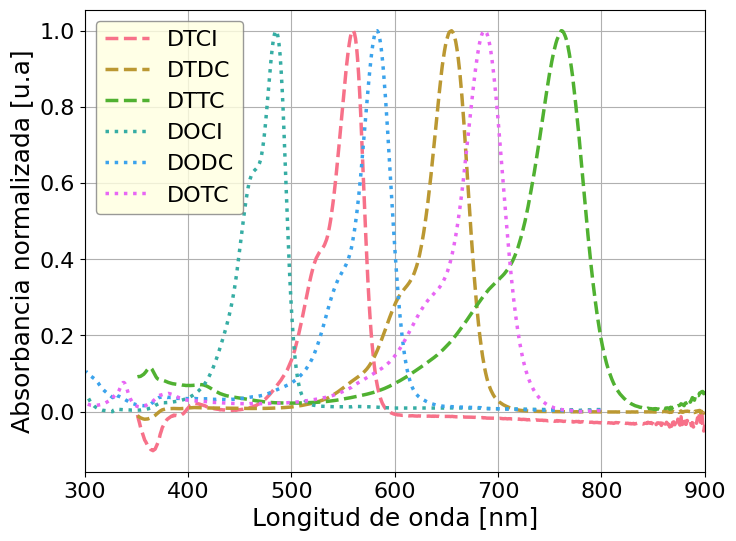

In [65]:
url_DTCI = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSVSD1HanKqrSdlRp2bpG-QQQ4_4_yi0DHFg6WsAon0DgKRhqMNhsY8apGDx95f0wuOAIc7ZxTGA3Ip/pub?gid=349975917&single=true&output=tsv"
url_DTTC = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSVSD1HanKqrSdlRp2bpG-QQQ4_4_yi0DHFg6WsAon0DgKRhqMNhsY8apGDx95f0wuOAIc7ZxTGA3Ip/pub?gid=643802181&single=true&output=tsv"
url_DTDC = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSVSD1HanKqrSdlRp2bpG-QQQ4_4_yi0DHFg6WsAon0DgKRhqMNhsY8apGDx95f0wuOAIc7ZxTGA3Ip/pub?gid=297098652&single=true&output=tsv"
url_DOCI = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRPycKKvlN35T4dD0QwF62SjPbcczFowO6orkyydGwOIR8iW7_uTxhqyXcPGuArturV0mjrc3P1h_Cn/pub?gid=104235711&single=true&output=tsv"
url_DODC = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRPycKKvlN35T4dD0QwF62SjPbcczFowO6orkyydGwOIR8iW7_uTxhqyXcPGuArturV0mjrc3P1h_Cn/pub?gid=660903410&single=true&output=tsv"
url_DOTC = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRPycKKvlN35T4dD0QwF62SjPbcczFowO6orkyydGwOIR8iW7_uTxhqyXcPGuArturV0mjrc3P1h_Cn/pub?gid=1173218893&single=true&output=tsv"


fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

urls = [url_DTCI, url_DTDC, url_DTTC,url_DOCI , url_DODC , url_DOTC]
labels = ['DTCI', 'DTDC', 'DTTC', "DOCI" ,  "DODC" , "DOTC"]

sns_colors = sns.color_palette("husl", n_colors=len(urls), desat=None) #paleta de colores que distingue lucas

for i in range(0,len(urls)):
  x, y = obtener_variables(urls[i])
  filtro = x > 300
  x_filtrado = x[filtro]
  y_filtrado = y[filtro]

  # Desplazar los valores para que sean todos positivos
  if min(y_filtrado) < -0.1:
    y_filtrado = y_filtrado - min(y_filtrado)

  # Normalizar el espectro
  y_norm = y_filtrado / max(y_filtrado)

  if i <= 2:
    ax.plot(x_filtrado, y_norm, lw=2.5, color=sns_colors[i], label=labels[i], linestyle='--')
  else:
    ax.plot(x_filtrado, y_norm, lw=2.5, color=sns_colors[i], label=labels[i], linestyle=':')

ax.set_xlim(300, 900)
ax.set_xlabel('Longitud de onda [nm]', fontsize=18)
ax.set_ylabel('Absorbancia normalizada [u.a]', fontsize=18)
plt.legend(edgecolor="gray", facecolor="lightyellow", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.savefig("A vs lambda.pdf", format="pdf",bbox_inches="tight", pad_inches=0 )
plt.show()

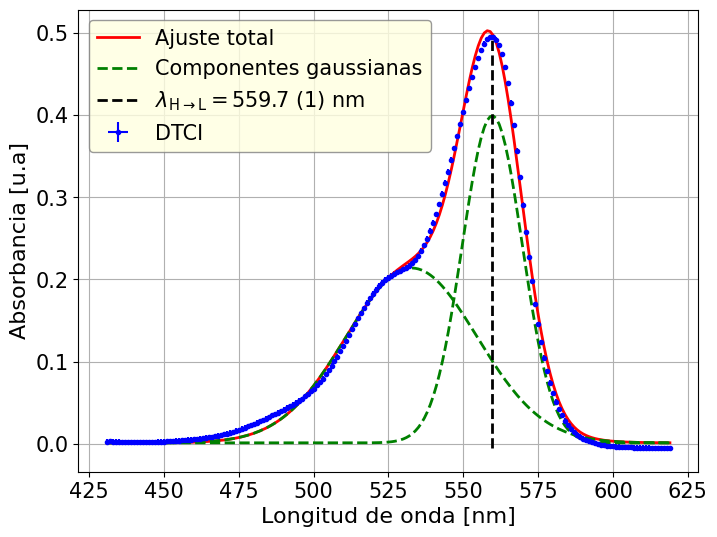

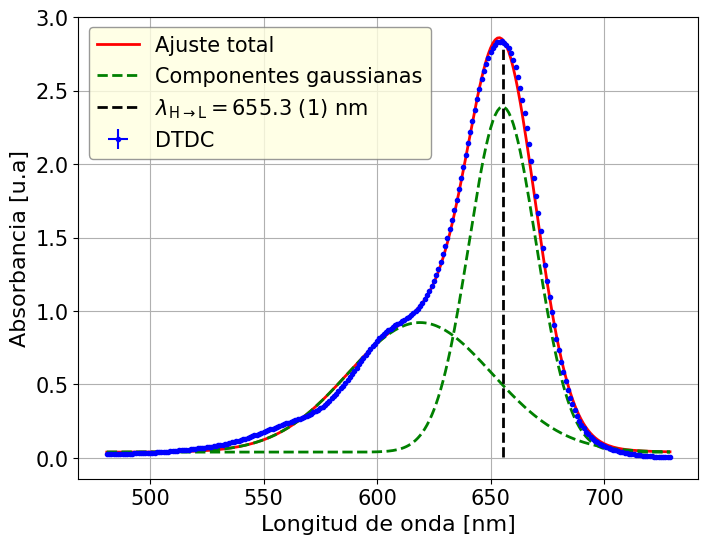

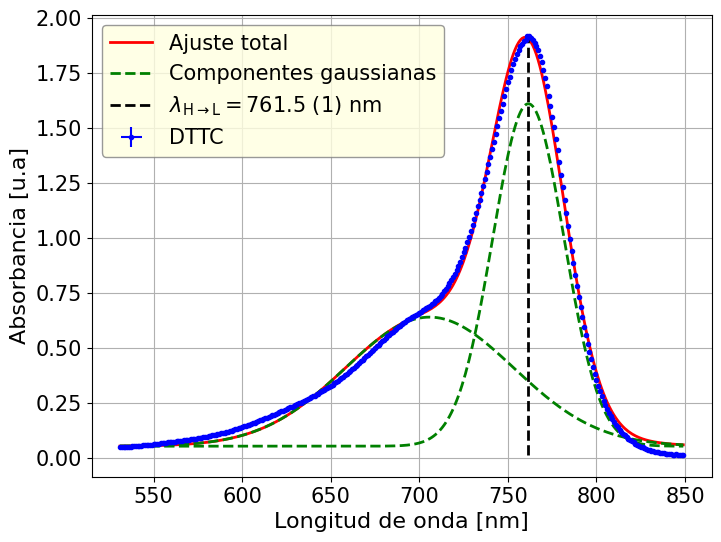

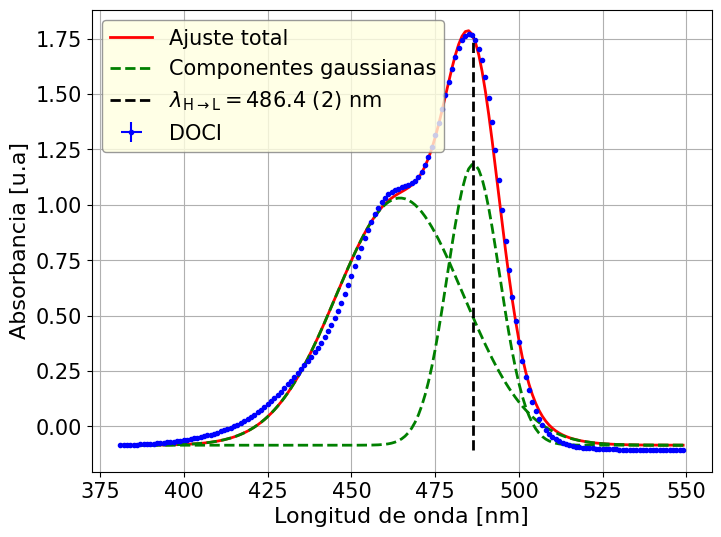

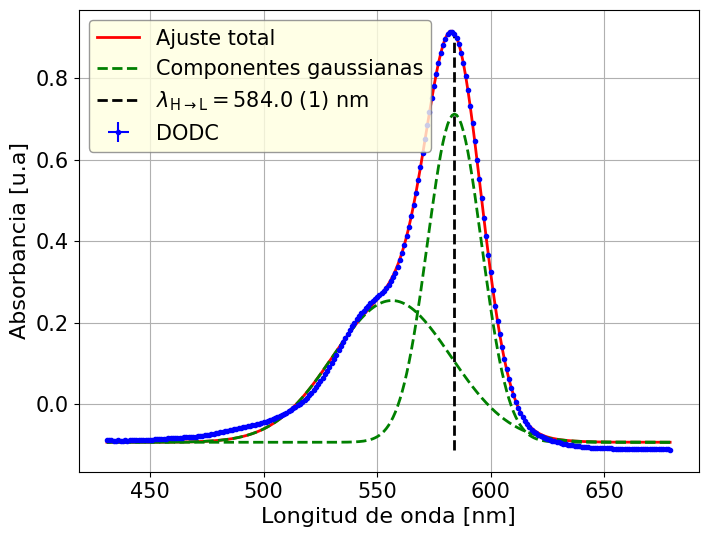

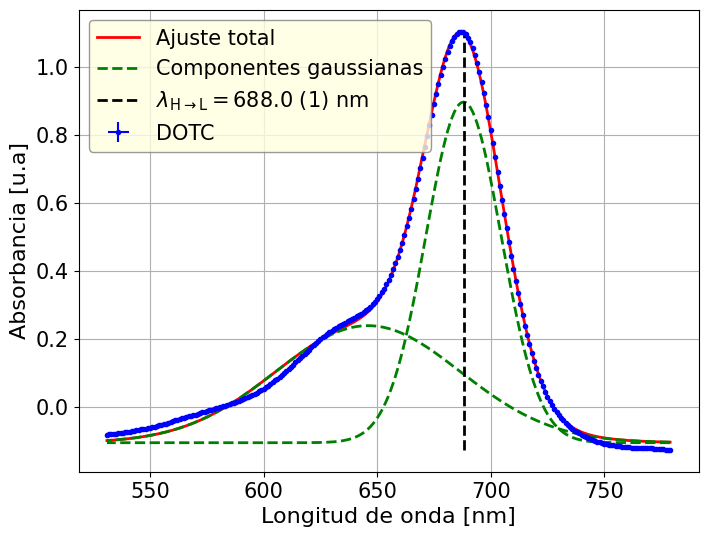

In [66]:

#ventantas de absorción en nm
ranges = [(430, 620), (480, 730),(530, 850) ,(380, 550) , (430, 680) , (530, 780)]  #Longitudes de onda donde se observan los picos de cada espectro

#parámetros inciales para ajustar dos gaussianas en cada ventana
beta0=[[0.5,560,10,0.25,530,10,0],[2.8,650,15,0.8,600,10,0],  [1.8,750,10,0.6,690,20,0], [1.3,486,7.7,1,465,18,0] , [0.85,580,5,0.2,550,10,0] , [1,680,5,0.2,620,10,0]]  #Parámetros iniciales para el ajuste: [A_1 , mu_1 , sigma_1 , A_2 , mu_2, sigma_2 , offset]

#listas para guardar resultados. la próxima usemos diccionarios, esto es horrible :)
params = []
params_err = []
lambda_d_TIO = []
lambda_s_TIO = []
err_lambda_d_TIO = []
err_lambda_s_TIO = []
lambda_d_OXO = []
lambda_s_OXO = []
err_lambda_d_OXO = []
err_lambda_s_OXO = []
cocientes_OXO = []
cocientes_TIO = []
err_cocientes_OXO = []
err_cocientes_TIO = []

#un bucle que recorre todas los espectros y ajusta las dos gaussianas en cada ventana
for i in range(0,len(urls)):
  fig, ax = plt.subplots(figsize=(8, 6))
  x , y = obtener_variables(urls[i])
  xmin, xmax = ranges[i]
  mask = (x > xmin) & (x < xmax)
  x = x[mask]
  y = y[mask]
  parametros, err_parametros = ajuste_gaussianas(x, y, errx=0.1, erry=0.003, beta0=beta0[i])
  params.append(parametros)
  params_err.append(err_parametros)
  if 0<=i<3:
    lambda_d_TIO.append(parametros[1])
    lambda_s_TIO.append(parametros[4])
    err_lambda_d_TIO.append(np.sqrt(2*np.log(2)*err_parametros[1]))
    err_lambda_s_TIO.append(np.sqrt(2*np.log(2)*err_parametros[4]))
    cocientes_TIO.append(parametros[3]/parametros[0])
    err_cocientes_TIO.append((parametros[3]/parametros[0])*np.sqrt((err_parametros[1]/parametros[1])**2+(err_parametros[3]/parametros[3])**2))
  else:
    lambda_d_OXO.append(parametros[1])
    err_lambda_d_OXO.append(np.sqrt(2*np.log(2)*err_parametros[1]))
    lambda_s_OXO.append(parametros[4])
    err_lambda_s_OXO.append(np.sqrt(2*np.log(2)*err_parametros[4]))
    cocientes_OXO.append(parametros[3]/parametros[0])
    err_cocientes_OXO.append((parametros[3]/parametros[0])*np.sqrt((err_parametros[1]/parametros[1])**2+(err_parametros[3]/parametros[3])**2))
  ax.errorbar(x,y,xerr=0.1,yerr=0.003,fmt='.', label=labels[i], c="b")
  ax.plot(x, gaussianas_odr(parametros, x), label=f'Ajuste total' , c="r", lw=2)
  ax.plot(x, gaussiana(x, parametros[0],parametros[1], parametros[2],parametros[-1]) , c="g", lw=2, linestyle ='--', label='Componentes gaussianas')
  ax.plot(x,gaussiana(x,parametros[3],parametros[4],parametros[5], parametros[6]), c="g", lw=2, linestyle ='--')
  ax.vlines(x=parametros[1], ymin=min(y),ymax=max(y), linestyle='--', color="black", lw=2, label = "$\\lambda_{\\mathrm{H}\\rightarrow \\mathrm{L}}=$"+ f"{parametros[1]:.1f} ({err_parametros[1]*10:.0f})"+ " nm")

  plt.legend(edgecolor="gray", facecolor="lightyellow", fontsize=15, loc ='upper left')
  ax.set_xlabel('Longitud de onda [nm]', fontsize=16)
  ax.set_ylabel('Absorbancia [u.a]', fontsize=16)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.grid()
  plt.savefig("Ajuste gaussianas"+labels[i]+".pdf", format="pdf", bbox_inches="tight", pad_inches=0 )
  plt.show()

In [67]:
print(lambda_d_TIO)
print(err_lambda_d_TIO)
print()
print(lambda_s_TIO)
print(err_lambda_s_TIO)
print()
print(lambda_d_OXO)
print(err_lambda_d_OXO)
print()
print(lambda_s_OXO)
print(err_lambda_s_OXO)

[np.float64(559.6992340173906), np.float64(655.2746002826647), np.float64(761.5408883054345)]
[np.float64(0.3520952419160852), np.float64(0.41688626783901533), np.float64(0.4503547398052484)]

[np.float64(532.7387183208034), np.float64(618.8847867005173), np.float64(705.7891584583654)]
[np.float64(1.1200719841562385), np.float64(1.305133218936817), np.float64(1.5518579695148675)]

[np.float64(486.4404599371317), np.float64(584.0493483026718), np.float64(688.040382706526)]
[np.float64(0.5141388188309177), np.float64(0.35714962729621413), np.float64(0.3825797378971366)]

[np.float64(464.50028939102083), np.float64(556.4783262408877), np.float64(645.9738200881939)]
[np.float64(0.9111851178501033), np.float64(1.1365019570035044), np.float64(1.3455091558888312)]


# Pozo infinito

d= 0.12565982147244928 +/- 0.0016450931858848275 nm
d= 0.12601202484355858 +/- 0.0010363582772209506 nm


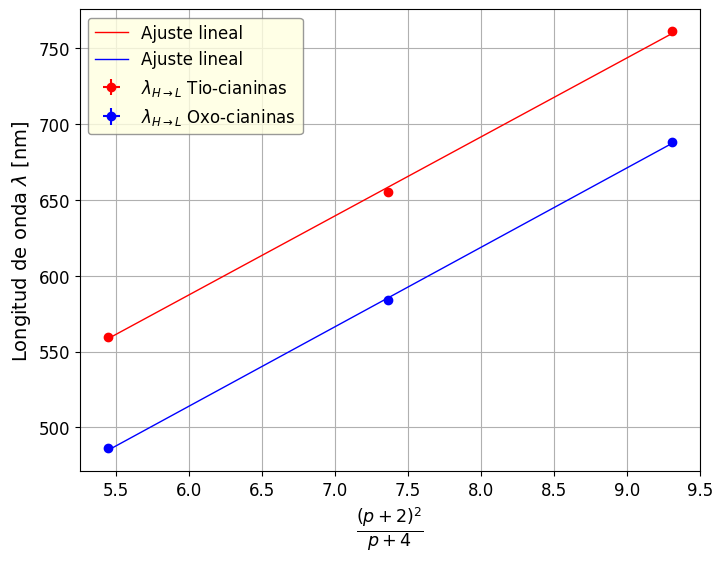

In [68]:
# en base al modelo de pozo infinito ajustamos una funcion lineal a lambda en funcion de q, siendo q=(p+2)^2/(p+4)
# de la pendiente obtenemos la longitud de enlace C-C.
p=np.array((5,7,9))
q = (p+2)**2/(p+4)
cte = (8*m_e*c/h)

lambda_m_TIA = np.array(lambda_d_TIO)
err_lambda_m_TIA = np.array(err_lambda_d_TIO)
params, err_params = ajuste_lineal(q, lambda_m_TIA, errx=0.0000001, erry=err_lambda_m_TIA, beta0=[10 , 200])
m=params[0]
b=params[1]
err_m=err_params[0]
err_b=err_params[1]

d_TIA= np.sqrt(m/cte)
err_d_TIA = err_m/(2*d_TIA*cte)
print("d=" ,d_TIA,"+/-",err_d_TIA,"nm")


fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(q,lambda_m_TIA,xerr=0,yerr=err_lambda_m_TIA,fmt='o', label="$\\lambda_{H\\rightarrow L}$ Tio-cianinas", c="r")
ax.plot(q, lineal(params, q), label=f'Ajuste lineal' , c="r", lw=1, zorder=100)

lambda_m_OXO = np.array(lambda_d_OXO)
err_lambda_m_OXO = np.array(err_lambda_d_OXO)

params, err_params = ajuste_lineal(q, lambda_m_OXO, errx=0.0000001, erry=err_lambda_m_OXO, beta0=[10 , 200])
m=params[0]
b=params[1]
err_m=err_params[0]
err_b=err_params[1]

d_OXO= np.sqrt(m/cte)
err_d_OXO = err_m/(2*d_OXO*cte)
print("d=" ,d_OXO,"+/-",err_d_OXO,"nm")

ax.errorbar(q,lambda_m_OXO,xerr=0,yerr=err_lambda_m_OXO,fmt='o', label="$\\lambda_{H\\rightarrow L}$ Oxo-cianinas", c="b")
ax.plot(q, lineal(params, q), label=f'Ajuste lineal ' , c="b", lw=1, zorder=100)
ax.set_xlabel(r'$\frac{(p+2)^2}{p+4}$', fontsize=18)
ax.set_ylabel('Longitud de onda $\\lambda$ [nm]', fontsize=14)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.legend(edgecolor="gray", facecolor="lightyellow", fontsize=12)
plt.grid()
plt.savefig("Ajuste lineal lambda vs p.pdf", format="pdf", bbox_inches="tight", pad_inches=0  )
plt.show()


[0.12601202 0.12565982]
[0.00103636 0.00164509]
0.12583592315800393
0.0019443173786728


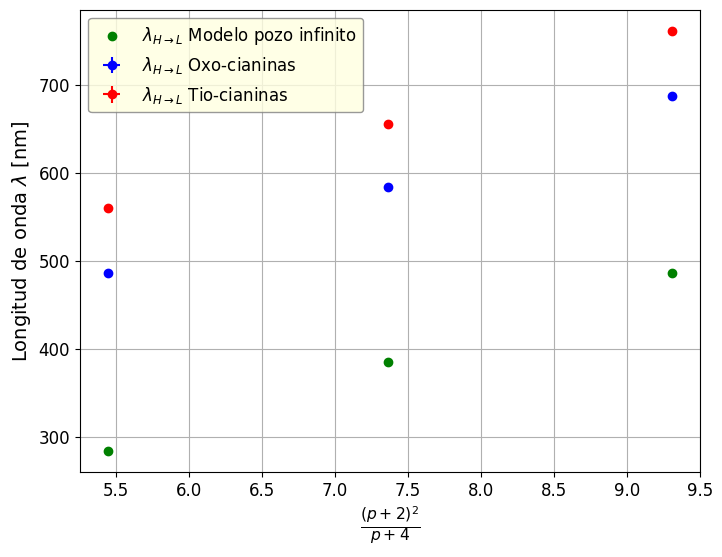

In [69]:
#ahora calculamos las longitudes de onda de transición HOMO-LUMO que predice el modelo de pozo infinito usando el valor que obtuvimos para d
p_1 = np.array((5,7,9))
x_1 = (p_1+2)**2/(p_1+4)
y_1 = lambda_m_OXO
err_y_1 = err_lambda_m_OXO
p_2 = np.array((5,7,9))
x_2 = (p_2+2)**2/(p_2+4)
y_2 = lambda_m_TIA
err_y_2 = err_lambda_m_TIA

d = np.array((d_OXO, d_TIA))
err_d = np.array((err_d_OXO, err_d_TIA))
print(d)
print(err_d)

d_prom = np.mean(d)
err_d_prom = np.sqrt(np.sum(err_d**2))
print(d_prom)
print(err_d_prom)

y_modelo = cte*(d_prom**2)*(p_1+2)**2/(p_1+4)


fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(x_1,y_1,xerr=0,yerr=err_y_1,fmt='o', label="$\\lambda_{H\\rightarrow L}$ Oxo-cianinas", c="b")
ax.errorbar(x_2,y_2,xerr=0,yerr=err_y_2,fmt='o', label="$\\lambda_{H\\rightarrow L}$ Tio-cianinas", c="r")
ax.scatter(x_1, y_modelo, marker='o', label='$\\lambda_{H\\rightarrow L}$ Modelo pozo infinito', c='green')
ax.set_xlabel(r'$\frac{(p+2)^2}{p+4}$', fontsize=16)
ax.set_ylabel('Longitud de onda $\\lambda$ [nm]', fontsize=14)
plt.legend(edgecolor="gray", facecolor="lightyellow", fontsize=12)
plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.grid()
plt.savefig("comparacion.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

0.26484312029541807 0.0023891861294875315
0.3507119085744267 0.0028797456126453424


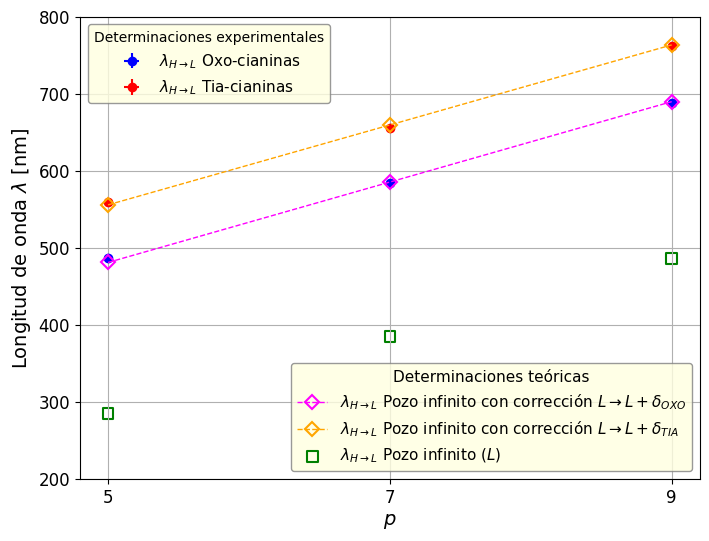

In [70]:
def correccion_modelo(beta, x):  #modelo de pozo infinito con la incorporación del ancho efectivo
  delta = beta[0]
  return cte*((x+2)*d_prom + delta)**2/(x+4)

def ajuste_modelo(x, y, errx, erry, beta0):
  model = Model(correccion_modelo)
  data = RealData(x, y, sx = errx, sy = erry)
  odr = ODR(data, model, beta0=beta0)
  out = odr.run()
  params = out.beta
  params_err = out.sd_beta
  return params, params_err


x , y = [p_1 , p_2] , [y_1 , y_2]
erry = [err_y_1 , err_y_2]
labels = ['Oxo' , 'Tia']
colors = ['b','r','magenta','orange']

fig, ax = plt.subplots(figsize=(8, 6))

handles_exp = []   # leyenda de experimentales
labels_exp = []
handles_mod = []   # leyenda de modelos/ajustes
labels_mod = []

for i in range(0,len(x)):
    params, err_params = ajuste_modelo(x[i], y[i], errx=1e-7, erry=erry[i], beta0=[0])
    delta = params[0]
    err_delta = err_params[0]
    print(delta , err_delta)

    # puntos experimentales
    h1 = ax.errorbar(x[i], y[i], xerr=0, yerr=erry[i],
                     fmt='o', label="$\\lambda_{H\\rightarrow L}$ "+labels[i]+"-cianinas",
                     c=colors[i])
    handles_exp.append(h1)
    labels_exp.append(h1.get_label())

    # ajustes
    h2, = ax.plot(x[i], correccion_modelo(params, x[i]),
                  label='$\\lambda_{H\\rightarrow L}$ '+'Pozo infinito con corrección $L\\rightarrow L+\\delta_{'+labels[i].upper()+'}$',
                  c=colors[i+2], marker='D', mfc='none', linestyle='--', lw=1, zorder=100,markersize=7, mew=1.5)
    handles_mod.append(h2)
    labels_mod.append(h2.get_label())

# modelo base
h3 = ax.scatter(p_1 , y_modelo, label='$\\lambda_{H\\rightarrow L}$ Pozo infinito ($L$)', edgecolors='green', marker="s",facecolors='none',lw=1.5,s=60)
handles_mod.append(h3)
labels_mod.append(h3.get_label())

ax.set_xlabel(r'$p$', fontsize=14)
plt.xticks(p_1 , fontsize=12)
ax.set_ylim(200,800)
plt.yticks(fontsize=12)
ax.set_ylabel('Longitud de onda $\\lambda$ [nm]', fontsize=14)
ax.grid()

# Primera leyenda (experimental)
legend1 = ax.legend(handles_exp, labels_exp, loc='upper left',
                    edgecolor="gray", facecolor="lightyellow", fontsize=11, title = 'Determinaciones experimentales')
ax.add_artist(legend1)

# Segunda leyenda (modelos)
ax.legend(handles_mod, labels_mod, loc='lower right',
          edgecolor="gray", facecolor="lightyellow", fontsize=11,title = 'Determinaciones teóricas',title_fontsize=11)
plt.savefig('Correccion1.pdf', format='pdf', bbox_inches="tight", pad_inches=0 )
plt.show()

# Pozo finito

/tmp/ipython-input-1228561264.py:53: RuntimeWarning: invalid value encountered in sqrt
  return np.where(y>=0, np.sqrt(y), np.nan)


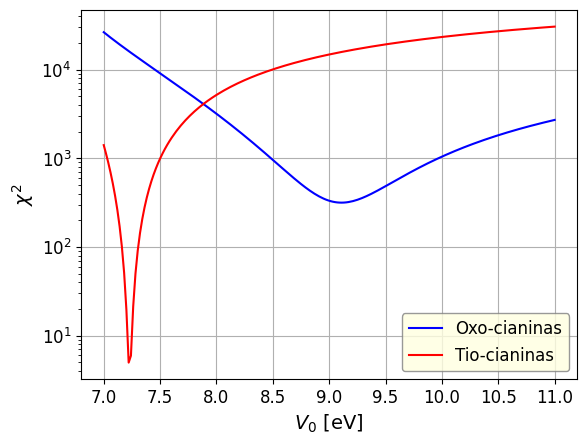

In [71]:
p = [5,7,9]
lambdas_OXO = {}
lambdas_TIA = {}
for i , p in enumerate(p):
  lambdas_OXO[p] = lambda_m_OXO[i]
  lambdas_TIA[p] = lambda_m_TIA[i]


def _chi2(V0: float , lambdas: dict[int, float]):

  total = 0

  for p , lambda_exp in lambdas.items():
      lambda_mod = obtener_delta_E(p,V0)  #obtener_delta_E es la función que calcula la energía de transición HOMO-LUMO predicha por el modelo de pozo finito, a partir de las intersecciones
      if np.isnan(lambda_mod): continue
      else:
        total += (lambda_exp-lambda_mod)**2
  return np.nan if total == 0 else total

chi2 = np.vectorize(_chi2)

V0s = np.linspace(7,11,200)

plt.plot(V0s, chi2(V0s, lambdas_OXO) , label="Oxo-cianinas", c = 'b')
plt.plot(V0s, chi2(V0s, lambdas_TIA)  , label="Tio-cianinas", c='r')
plt.xlabel("$V_0$ [eV]", fontsize=14)
plt.ylabel("$\\chi^2$" , fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale("log")
plt.legend(edgecolor="gray", facecolor="lightyellow", fontsize=12)
plt.grid('True')
plt.savefig("chi.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()


In [72]:
# --- Función para segunda derivada numérica ---
def second_derivative(f, x, args=(), dx=1e-6):
    """Derivada segunda numérica de f en x."""
    return (f(x + dx, *args) - 2*f(x, *args) + f(x - dx, *args)) / dx**2

# --- Wrapper para chi² ---
def chi2_wrapper(V0, lambdas):
    return _chi2(V0, lambdas)

# --- Función para minimizar y calcular incertidumbre ---
def optimizar_V0(lambdas, bounds=(7,11)):
    # Minimización
    res = minimize_scalar(
        chi2_wrapper,
        bounds=bounds,
        args=(lambdas,),
        method='bounded'
    )
    V0_opt = res.x
    chi2_min = res.fun
    # Segunda derivada numérica
    chi2_dd = second_derivative(chi2_wrapper, V0_opt, args=(lambdas,))
    # Incertidumbre
    sigma_V0 = 1 / np.sqrt(chi2_dd) if chi2_dd > 0 else np.nan

    return V0_opt, chi2_min, sigma_V0, res.success

# --- Aplicar a ambos datasets ---
V0_OXO, chi2_OXO, sigma_V0_OXO, exito_OXO = optimizar_V0(lambdas_OXO)
V0_TIA, chi2_TIA, sigma_V0_TIA, exito_TIA = optimizar_V0(lambdas_TIA)

# --- Resultados ---
print("OXO:")
print(" V0 óptimo:", V0_OXO)
print(" chi² mínimo:", chi2_OXO)
print(" Incertidumbre:", sigma_V0_OXO)
print(" Éxito?:", exito_OXO)

print("\nTIA:")
print(" V0 óptimo:", V0_TIA)
print(" chi² mínimo:", chi2_TIA)
print(" Incertidumbre:", sigma_V0_TIA)
print(" Éxito?:", exito_TIA)


/tmp/ipython-input-1228561264.py:53: RuntimeWarning: invalid value encountered in sqrt
  return np.where(y>=0, np.sqrt(y), np.nan)


OXO:
 V0 óptimo: 9.108790668141822
 chi² mínimo: 317.0470004509275
 Incertidumbre: 0.019667955904887065
 Éxito?: True

TIA:
 V0 óptimo: 7.229773362938923
 chi² mínimo: 3.5567963358959847
 Incertidumbre: 0.0051758729105058614
 Éxito?: True


/tmp/ipython-input-1228561264.py:53: RuntimeWarning: invalid value encountered in sqrt
  return np.where(y>=0, np.sqrt(y), np.nan)


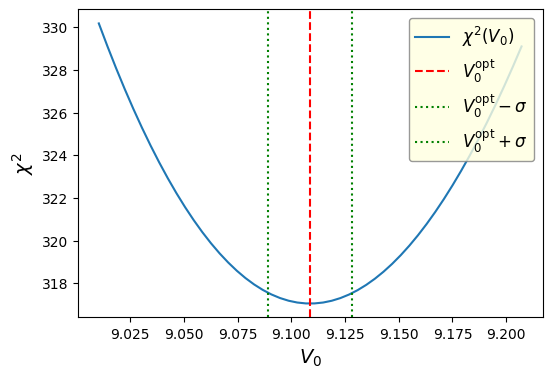

/tmp/ipython-input-1228561264.py:53: RuntimeWarning: invalid value encountered in sqrt
  return np.where(y>=0, np.sqrt(y), np.nan)


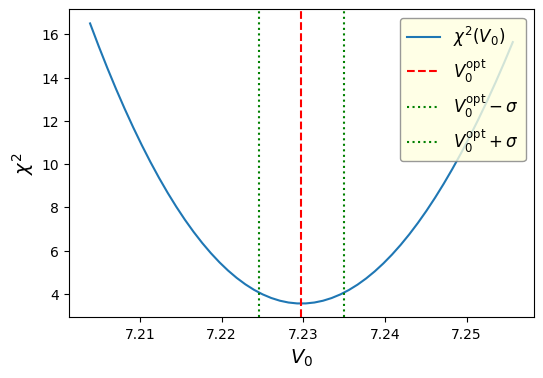

In [73]:
def graficar_chi2(lambdas, V0_opt, sigma_V0, nombre="Dataset"):
    # Crear un rango alrededor del mínimo
    V0_vals = np.linspace(V0_opt - 5*sigma_V0, V0_opt + 5*sigma_V0, 50)
    chi2_vals = [chi2(V0, lambdas) for V0 in V0_vals]

    plt.figure(figsize=(6,4))
    plt.plot(V0_vals, chi2_vals, label=r'$\chi^2(V_0)$')
    plt.axvline(V0_opt, color='red', linestyle='--', label=r'$V_0^\mathrm{opt}$')
    plt.axvline(V0_opt - sigma_V0, color='green', linestyle=':', label=r'$V_0^\mathrm{opt}-\sigma$')
    plt.axvline(V0_opt + sigma_V0, color='green', linestyle=':', label=r'$V_0^\mathrm{opt}+\sigma$')
    plt.xlabel(r'$V_0$', fontsize=14)
    plt.ylabel(r'$\chi^2$', fontsize=14)

    plt.legend( loc='upper right',
          edgecolor="gray", facecolor="lightyellow", fontsize=12)
    plt.savefig(f"min_chi2_{nombre}.pdf", format="pdf")
    plt.show()

# Ejemplo para OXO
graficar_chi2(lambdas_OXO, V0_OXO, sigma_V0_OXO, nombre="OXO")

# Ejemplo para TIA
graficar_chi2(lambdas_TIA, V0_TIA, sigma_V0_TIA, nombre="TIA")


/tmp/ipython-input-1228561264.py:53: RuntimeWarning: invalid value encountered in sqrt
  return np.where(y>=0, np.sqrt(y), np.nan)


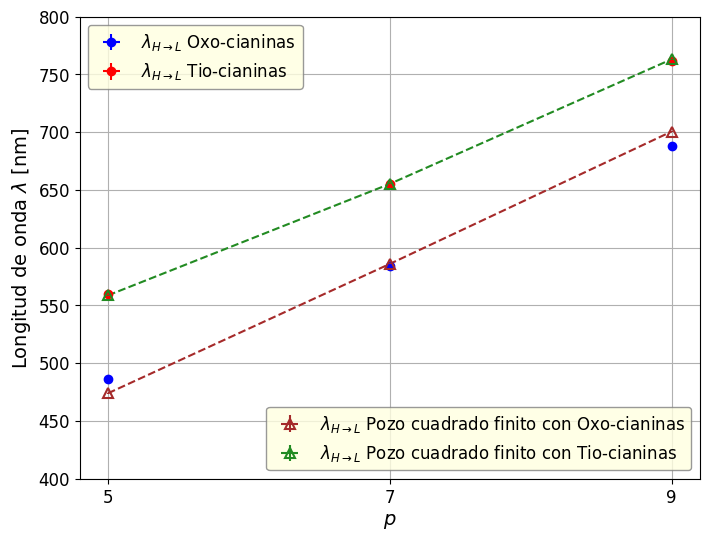

In [74]:
def delta_E_ajuste(v0, sigma_v0):
    energies = []
    sigma_energies = []
    for p in [5, 7, 9]:
        # We will manually propapate the uncertainty in V0 to the energy levels,
        # by calculating the energies at V0, V0 + 1 sigma, and V0 - 1 sigma.
        # This is an approximation, but it's good enough for our purposes.
        energies_nom = obtener_delta_E(p , v0)
        energies_p1sigma = obtener_delta_E(p, v0 + sigma_v0)
        energies_m1sigma = obtener_delta_E(p, v0 - sigma_v0)


        # We first need to check that we have an ith state when we calculated the energy levels with V0 +/- 1 sigma
        unc_p1sigma = abs(energies_p1sigma - energies_nom)
        unc_m1sigma = abs(energies_m1sigma - energies_nom)

        # Since the uncertainties package does not support asymmetric uncertainties,
        # we will symmetrize them by taking the largest uncertainty
        energies.append(energies_nom)
        sigma_energies.append(max(unc_p1sigma, unc_m1sigma))

    return np.array(energies), np.array(sigma_energies)

E_OXO, sigma_OXO = delta_E_ajuste(V0_OXO, sigma_V0_OXO)
E_TIA, sigma_TIA = delta_E_ajuste(V0_TIA, sigma_V0_TIA)
p=np.array((5,7,9))

fig, ax = plt.subplots(figsize=(8, 6))

# --- Pozo cuadrado finito ---
h1 = plt.errorbar(p , E_OXO, xerr=0, yerr=sigma_OXO,markersize=7,
                  fmt='^', mfc='none', c='brown',mew=1.5,
                  label="$\\lambda_{H\\rightarrow L}$ Pozo cuadrado finito con Oxo-cianinas",
                  zorder=100)

h2 = plt.errorbar(p , E_TIA, xerr=0, yerr=sigma_TIA,
                  fmt='^', mfc='none',markersize=7,c='#228B22',mew=1.5,
                  label="$\\lambda_{H\\rightarrow L}$ Pozo cuadrado finito con Tio-cianinas",
                  zorder=100)

# --- Líneas experimentales (van en la 1ra leyenda) ---
h3 = plt.errorbar(p, lambda_m_OXO, xerr=0, yerr=err_lambda_m_OXO,
                  fmt='o', c='b',
                  label="$\\lambda_{H\\rightarrow L}$ Oxo-cianinas")

h4 = plt.errorbar(p, lambda_m_TIA, xerr=0, yerr=err_lambda_m_TIA,
                  fmt='o', c='r',
                  label="$\\lambda_{H\\rightarrow L}$ Tio-cianinas")

# --- Modelo pozo infinito ---
#h5 = plt.errorbar(p_1 , y_modelo,xerr=0, yerr=err_lambda_m_TIA, label='$\\lambda_{H\\rightarrow L}$ Pozo infinito ($L$)', fmt="s",color='green', mfc='none',lw=1.5,markersize=7,)

# Configuración ejes
plt.xlabel("$p$", fontsize=14)
plt.ylabel("Longitud de onda $\\lambda$ [nm]", fontsize=14)
plt.xticks(p, fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim(400,800)
plt.plot(p, E_OXO,c='brown', linestyle='--')
plt.plot(p, E_TIA,c='#228B22', linestyle='--')
plt.grid()

# --- Leyenda 1: solo experimentales ---
legend1 = ax.legend([h3, h4],
                    ["$\\lambda_{H\\rightarrow L}$ Oxo-cianinas",
                     "$\\lambda_{H\\rightarrow L}$ Tio-cianinas"],
                    loc="upper left",
                    edgecolor="gray", facecolor="lightyellow", fontsize=12)
ax.add_artist(legend1)  # importante

# --- Leyenda 2: modelos ---
ax.legend([h1, h2],
          ["$\\lambda_{H\\rightarrow L}$ Pozo cuadrado finito con Oxo-cianinas",
           "$\\lambda_{H\\rightarrow L}$ Pozo cuadrado finito con Tio-cianinas"],
          loc="lower right",
          edgecolor="gray", facecolor="lightyellow", fontsize=12)
plt.savefig("ajuste_pozo_finito.pdf", format="pdf",bbox_inches='tight',pad_inches=0)
plt.show()


In [75]:
lambda_d_fmt = [f"{val:.2f} ± {err:.2f}" for val, err in zip(lambda_d_TIO, err_lambda_d_TIO)]
lambda_s_fmt = [f"{val:.2f} ± {err:.3f}" for val, err in zip(lambda_s_TIO, err_lambda_s_TIO)]
cociente_fmt = [f"{val:.3f} ± {err:.3f}" for val, err in zip(cocientes_TIO, err_cocientes_TIO)]
# Construir DataFrame
df = pd.DataFrame({
    "$p$": p,
    r"$\lambda_{0-0}$": lambda_s_fmt,
    r"$\lambda_{1-1}$": lambda_d_fmt,
    r"$A_{0-0}/A_{0-1}$": cociente_fmt
})

print(df)
#crear un csv con el df
pd.DataFrame(df).to_csv("datos_ajuste_pozo_cuadrado.csv", index=False)

   $p$ $\lambda_{0-0}$ $\lambda_{1-1}$ $A_{0-0}/A_{0-1}$
0    5  532.74 ± 1.120   559.70 ± 0.35     0.535 ± 0.009
1    7  618.88 ± 1.305   655.27 ± 0.42     0.375 ± 0.007
2    9  705.79 ± 1.552   761.54 ± 0.45     0.377 ± 0.006


In [76]:
lambda_d_fmt = [f"{val:.2f} ± {err:.2f}" for val, err in zip(lambda_d_OXO, err_lambda_d_OXO)]
lambda_s_fmt = [f"{val:.2f} ± {err:.3f}" for val, err in zip(lambda_s_OXO, err_lambda_s_OXO)]
cociente_fmt = [f"{val:.3f} ± {err:.3f}" for val, err in zip(cocientes_OXO, err_cocientes_OXO)]
# Construir DataFrame
df = pd.DataFrame({
    "$p$": p,
    r"$\lambda_{0-0}$": lambda_s_fmt,
    r"$\lambda_{1-1}$": lambda_d_fmt,
    r"$A_{0-0}/A_{0-1}$": cociente_fmt
})

print(df)
#crear un csv con el df
pd.DataFrame(df).to_csv("datos_ajuste_pozo_cuadrado OXO.csv", index=False)

   $p$ $\lambda_{0-0}$ $\lambda_{1-1}$ $A_{0-0}/A_{0-1}$
0    5  464.50 ± 0.911   486.44 ± 0.51     0.879 ± 0.011
1    7  556.48 ± 1.137   584.05 ± 0.36     0.432 ± 0.008
2    9  645.97 ± 1.346   688.04 ± 0.38     0.344 ± 0.007
